Comparando as performances
========================================



## Introdução



Durante o primeiro mês do curso de Redes Neurais e Algoritmos Genéticos, fomos apresentados a diferentes algoritmos, como é o caso do algoritmo de busca aleatória, busca em grade e algoritmos genéticos. Dentre tais opções, torna-se interessante saber em que situações usar cada um dos algoritmos.

## Objetivo



O objetivo do presente experimento é de avaliar cada um dos algoritmos em função dos valores de fitness retornados e de tempo para a execução de código.

## Importações



In [3]:
import time
import psutil
import random
import itertools
import numpy as np
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt

from funcoes import funcao_objetivo_cb, individuo_cb
from funcoes import populacao_cb as cria_populacao_inicial
from funcoes import funcao_objetivo_pop_cb as funcao_objetivo_pop
from funcoes import selecao_roleta_max as funcao_selecao
from funcoes import cruzamento_ponto_simples as funcao_cruzamento
from funcoes import mutacao_cb as funcao_mutacao

## Códigos e discussão



Como forma de testar o problema das caixas binárias em relação ao método de busca aleatória, algoritmo genético e busca em grade, o método proposto foi:

- Definir funções com os métodos;
- Variar as constantes de gene e do tamanho da população, no caso de algoritmos genéticos;
- Armazenar os dados em um dataframe para poder analisar.



In [4]:
# Constantes

NUM_GERACOES = 5
CHANCE_CRUZAMENTO = 0.5
CHANCE_MUTACAO = 0.05

In [5]:
def busca_aleatoria():
    inicio = time.time()
    candidatos = {}
    resultado_value = float('-inf')

    for n in range(TAMANHO_POP):
        candidato = individuo_cb(N_GENES)
        fobj = funcao_objetivo_cb(candidato)
        candidatos.update({str(candidato):fobj})
        
        mem = (psutil.Process().memory_info().rss / (1024 * 1024))
        cpu = multiprocessing.cpu_count()

        if fobj > resultado_value:
            resultado_value = fobj
            resultado_key = candidato
    
    fim = time.time()
    
    #print(f'Após {round(fim-inicio,5)} segundos, score de {resultado_value}')
    return round(fim-inicio,5), resultado_value, mem, cpu

In [6]:
def busca_em_grade():
    inicio = time.time()
    candidatos = {}
    resultado_value = float('-inf')
    
    for individuo in itertools.product([0,1], repeat=N_GENES):
        fobj = funcao_objetivo_cb(individuo)
        candidatos.update({str(individuo):fobj})
        
        mem = (psutil.Process().memory_info().rss / (1024 * 1024))
        cpu = multiprocessing.cpu_count()
        
        if fobj > resultado_value:
            resultado_value = fobj

    fim = time.time()
    #print(f'Após {round(fim-inicio,5)} segundos, score de {resultado_value}')
    return round(fim-inicio,5), resultado_value, mem, cpu

In [7]:
def algoritmo_genetico():
    inicio = time.time()
    
    populacao = cria_populacao_inicial(TAMANHO_POP, N_GENES)

    #print(f'População inicial de pontuação igual a {sum(funcao_objetivo_pop(populacao))}: \n{populacao}\n')

    for _ in range(NUM_GERACOES):
        fitness = funcao_objetivo_pop(populacao)
        populacao = funcao_selecao(populacao,fitness)

        # Pais são pares, mães são ímpares
        pais = populacao[0::2]
        maes = populacao[1::2]

        contador = 0

        for pai, mae in zip(pais,maes):
            if random.random() < CHANCE_CRUZAMENTO:
                # Vai acontecer cruzamento
                filho1, filho2 = funcao_cruzamento(pai,mae)
                populacao[contador] = filho1
                populacao[contador+1] = filho2
            contador += 2

        for n in range(len(populacao)):
            if random.random() <= CHANCE_MUTACAO:
                #print(f'Indivíduo mutado: {populacao[n]}',end=' ')
                populacao[n] = funcao_mutacao(populacao[n])
                #print(populacao[n])
    
        mem = (psutil.Process().memory_info().rss / (1024 * 1024))
        cpu = multiprocessing.cpu_count()
    
    fim = time.time()
    
    #print(f'Após {round(fim-inicio,5)} segundos, score de {max(fitness)}')
    return round(fim-inicio,5), max(fitness), mem, cpu

In [9]:
ba, ag = [], []

lista_tamanhos = [10]
lista_ngenes = range(10,1000,10)

for TAMANHO_POP, N_GENES in itertools.product(lista_tamanhos,lista_ngenes):
    tempo, score, memoria, cpus = busca_aleatoria()
    ba.append([TAMANHO_POP,N_GENES,tempo,score,memoria,cpus])
    
    tempo, score, memoria, cpus = algoritmo_genetico()
    ag.append([TAMANHO_POP,N_GENES,tempo,score,memoria, cpus])
    
ba_df = pd.DataFrame(ba, columns = ['Tamanho Pop','N Genes','Tempo','Score','Memória Usada','CPU'])
ag_df = pd.DataFrame(ag, columns = ['Tamanho Pop','N Genes','Tempo','Score','Memória Usada','CPU'])

### Importante

Como a busca em grade requer um tempo bastante grande de execução, valores baixos foram definidos para a execução. Além disso, a busca focou apenas na variação da quantidade de genes, a fim de comparar apenas esse quesito entre os métodos, ainda sendo possível observar como o tamanho da população para o algoritmo genético pode influenciar na execução do algoritmo.

In [10]:
bg = []

lista_tamanhos = [10]
lista_ngenes = range(10,20,5)

for TAMANHO_POP, N_GENES in itertools.product(lista_tamanhos,lista_ngenes):
    tempo, score, memoria, cpus = busca_em_grade()
    bg.append([TAMANHO_POP,N_GENES,tempo,score, memoria, cpus])

bg_df = pd.DataFrame(bg, columns = ['Tamanho Pop','N Genes','Tempo','Score','Memória Usada', 'CPU'])

In [11]:
ba_df_genes = ba_df.iloc[:10,1:]
ag_df_genes = ag_df.iloc[:10,1:]
bg_df_genes = bg_df.iloc[:10,1:]

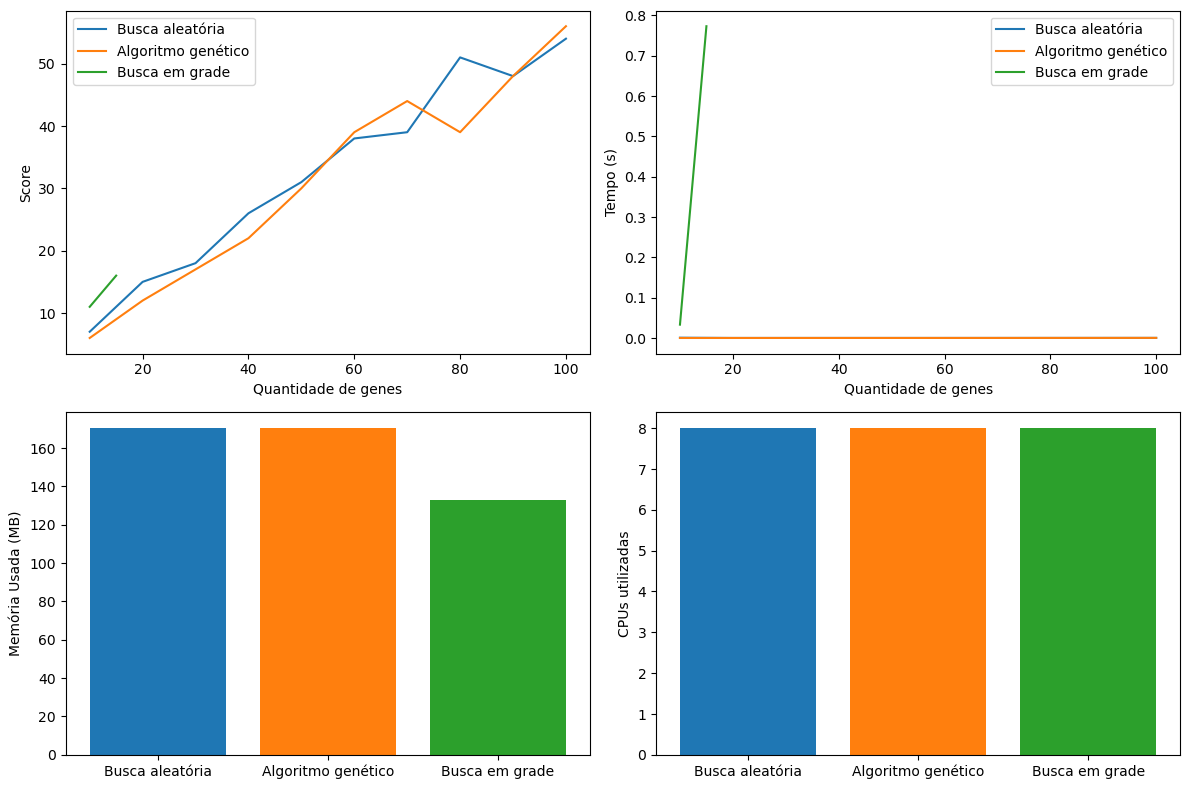

In [24]:
fig = plt.figure(figsize=(12,8))

fig.add_subplot(2,2,1)

plt.plot(np.array(ba_df_genes['N Genes']),np.array(ba_df_genes['Score']),label='Busca aleatória')
plt.plot(np.array(ag_df_genes['N Genes']),np.array(ag_df_genes['Score']),label='Algoritmo genético')
plt.plot(np.array(bg_df_genes['N Genes']),np.array(bg_df_genes['Score']),label='Busca em grade')

plt.xlabel('Quantidade de genes')
plt.ylabel('Score')
plt.legend()

fig.add_subplot(2,2,2)

plt.plot(np.array(ba_df_genes['N Genes']),np.array(ba_df_genes['Tempo']),label='Busca aleatória')
plt.plot(np.array(ag_df_genes['N Genes']),np.array(ag_df_genes['Tempo']),label='Algoritmo genético')
plt.plot(np.array(bg_df_genes['N Genes']),np.array(bg_df_genes['Tempo']),label='Busca em grade')

plt.xlabel('Quantidade de genes')
plt.ylabel('Tempo (s)')
plt.legend()

fig.add_subplot(2,2,3)

plt.bar('Busca aleatória',ba_df_genes['Memória Usada'])
plt.bar('Algoritmo genético',ag_df_genes['Memória Usada'])
plt.bar('Busca em grade',bg_df_genes['Memória Usada'])
plt.ylabel('Memória Usada (MB)')

fig.add_subplot(2,2,4)

plt.bar('Busca aleatória',ba_df_genes['CPU'])
plt.bar('Algoritmo genético',ag_df_genes['CPU'])
plt.bar('Busca em grade',bg_df_genes['CPU'])
plt.ylabel('Quantidade de CPUs utilizadas')

plt.tight_layout()

plt.show()

Ao analisar o início do plot de score, é evidente que a busca em grade gera os melhores resultados, por analisar todas as possibilidades possíveis, ao passo que os dois outros métodos aproximam-se da melhor resposta.

Uma vez que o tempo de execução do algoritmo de busca aleatória é grande, é gerada uma grande dificulta a visualização do tempo dos outros algoritmos. Dessa forma, buscou-se analisar apenas a busca aleatória e o algoritmo genético.

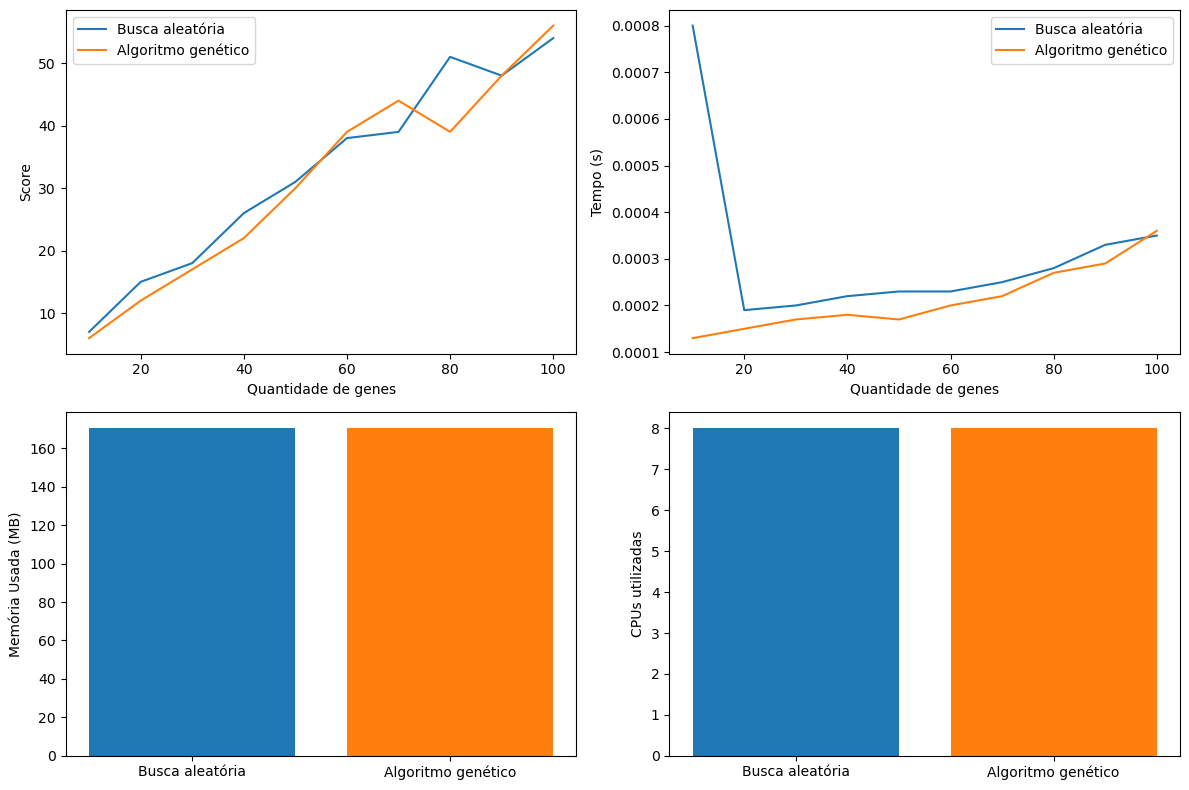

In [25]:
fig = plt.figure(figsize=(12,8))

fig.add_subplot(2,2,1)

plt.plot(np.array(ba_df_genes['N Genes']),np.array(ba_df_genes['Score']),label='Busca aleatória')
plt.plot(np.array(ag_df_genes['N Genes']),np.array(ag_df_genes['Score']),label='Algoritmo genético')

plt.xlabel('Quantidade de genes')
plt.ylabel('Score')
plt.legend()

fig.add_subplot(2,2,2)

plt.plot(np.array(ba_df_genes['N Genes']),np.array(ba_df_genes['Tempo']),label='Busca aleatória')
plt.plot(np.array(ag_df_genes['N Genes']),np.array(ag_df_genes['Tempo']),label='Algoritmo genético')

plt.xlabel('Quantidade de genes')
plt.ylabel('Tempo (s)')
plt.legend()

fig.add_subplot(2,2,3)

plt.bar('Busca aleatória',ba_df_genes['Memória Usada'])
plt.bar('Algoritmo genético',ag_df_genes['Memória Usada'])
plt.ylabel('Memória Usada (MB)')

fig.add_subplot(2,2,4)

plt.bar('Busca aleatória',ba_df_genes['CPU'])
plt.bar('Algoritmo genético',ag_df_genes['CPU'])
plt.ylabel('Quantidade de CPUs utilizadas')

plt.tight_layout()

plt.show()

Podemos também testar a variação da quantidade de indivíduos e de gerações para o algoritmo genético.

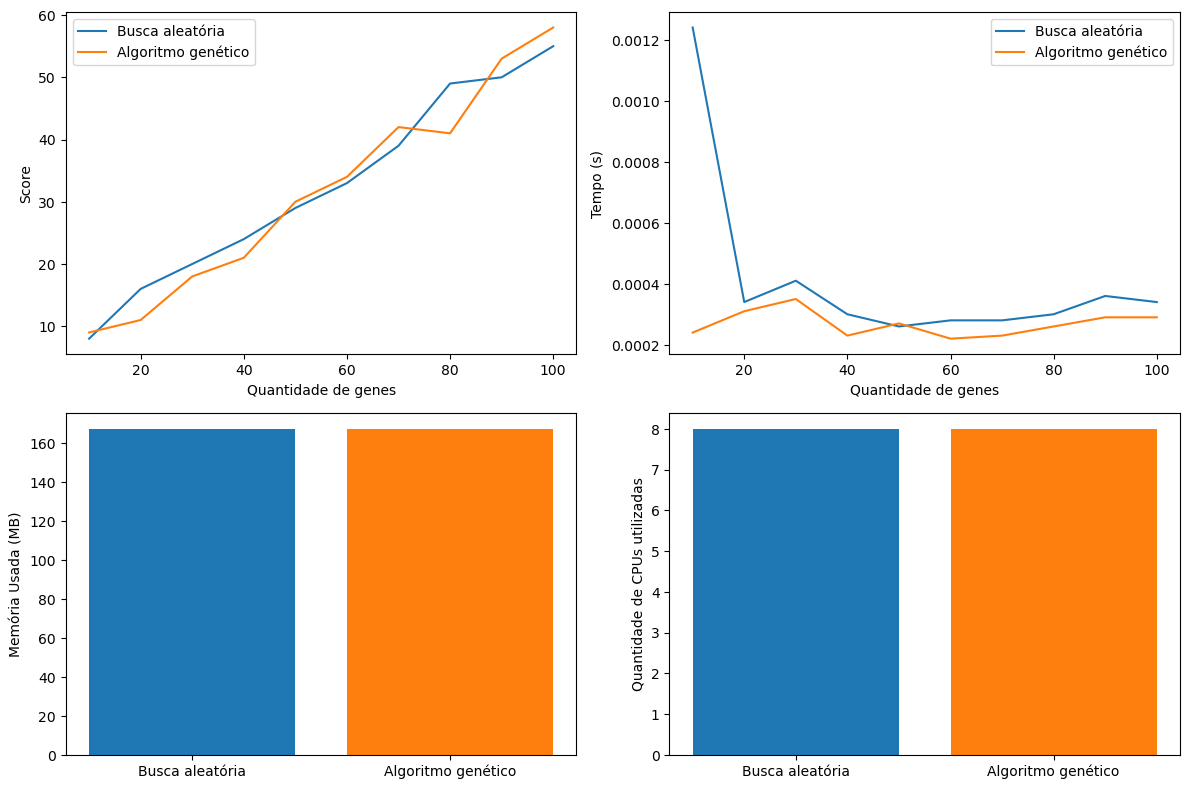

In [27]:
ba, ag = [], []

# Constantes

NUM_GERACOES = 3
CHANCE_CRUZAMENTO = 0.3
CHANCE_MUTACAO = 0.01

lista_tamanhos = [5]
lista_ngenes = range(10,1000,10)

for TAMANHO_POP, N_GENES in itertools.product(lista_tamanhos,lista_ngenes):
    tempo, score, memoria, cpus = busca_aleatoria()
    ba.append([TAMANHO_POP,N_GENES,tempo,score,memoria, cpus])
    
    tempo, score, memoria, cpus = algoritmo_genetico()
    ag.append([TAMANHO_POP,N_GENES,tempo,score,memoria,cpus])
    
ba_df = pd.DataFrame(ba, columns = ['Tamanho Pop','N Genes','Tempo','Score','Memória Usada','CPU'])
ag_df = pd.DataFrame(ag, columns = ['Tamanho Pop','N Genes','Tempo','Score','Memória Usada','CPU'])

ba_df_genes = ba_df.iloc[:10,1:]
ag_df_genes = ag_df.iloc[:10,1:]

fig = plt.figure(figsize=(12,8))

fig.add_subplot(2,2,1)

plt.plot(np.array(ba_df_genes['N Genes']),np.array(ba_df_genes['Score']),label='Busca aleatória')
plt.plot(np.array(ag_df_genes['N Genes']),np.array(ag_df_genes['Score']),label='Algoritmo genético')

plt.xlabel('Quantidade de genes')
plt.ylabel('Score')
plt.legend()

fig.add_subplot(2,2,2)

plt.plot(np.array(ba_df_genes['N Genes']),np.array(ba_df_genes['Tempo']),label='Busca aleatória')
plt.plot(np.array(ag_df_genes['N Genes']),np.array(ag_df_genes['Tempo']),label='Algoritmo genético')

plt.xlabel('Quantidade de genes')
plt.ylabel('Tempo (s)')
plt.legend()

fig.add_subplot(2,2,3)

plt.bar('Busca aleatória',ba_df_genes['Memória Usada'])
plt.bar('Algoritmo genético',ag_df_genes['Memória Usada'])
plt.ylabel('Memória Usada (MB)')

fig.add_subplot(2,2,4)

plt.bar('Busca aleatória',ba_df_genes['CPU'])
plt.bar('Algoritmo genético',ag_df_genes['CPU'])
plt.ylabel('Quantidade de CPUs utilizadas')

plt.tight_layout()

plt.show()

Outra avaliação importante de ser feita quando peé na implementação dos algoritmos

## Conclusão



No presente experimento, buscou-se analisar o desempenho dos algoritmos testados no problema das caixas binárias, onde os fatores principais de análise foram o score e o tempo necessário para a execução, haja visto que são questões fundamentais na análise de qualquer algoritmo.

Assim como esperado, para a busca em grade, que demanda a avaliação de todas as possibilidades do problema, o tempo foi enorme, tornando inviável a sua avaliação. Por outro lado, a busca aleatória e o algoritmo genético foram testados, obtendo valores bastante próximos, tanto para score quanto para tempo de execução. É interessante ainda dizer que a busca em grade encontrará os melhores valores, de forma a obter, por consequência, os valores mais altos de score, por conta de buscar por todas as possibilidades, algo inviável para uma grande parcela dos problemas.

Com a variação buscada neste notebook, o algoritmo genético demandou tempos maiores de execução em relação à busca aleatória, ao passo que os scores foram bastante similares. Quando os parâmetros do algoritmo genético foram alterados, o tempo foi mais próximo do que no caso anterior em grande partes dos testes, com pouca diferença nos valores de score. Isso pode indicar que, para problemas mais simples como no caso das caixas binárias, a aplicação de algoritmos genéticos pode não ser a mais adequada.

## Playground



Todo código de teste que não faz parte do seu experimento deve vir aqui. Este código não será considerado na avaliação.

